# On that notebooks I analysis the the labels crop difference between the the different states.

In [1]:
import os
import glob
import tqdm
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
import rasterio
import numpy as np
from matplotlib.patches import Polygon as MplPolygon
import os
import glob
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle
from collections import defaultdict
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import numpy as np
#avoid the all warning
import warnings
warnings.filterwarnings("ignore") 

fontsize_pt = 10
text_width_pt = 505.89
inches_per_pt = 1.0 / 72.27
fig_width = text_width_pt * inches_per_pt
fig_height = fig_width * 0.65

params = {
    'figure.figsize': (fig_width, fig_height),
    'font.size': fontsize_pt,
    'axes.labelsize': fontsize_pt,
    'legend.fontsize': fontsize_pt * 0.9,
    'xtick.labelsize': fontsize_pt * 0.8,
    'ytick.labelsize': fontsize_pt * 0.8,
    'text.usetex': True,
    'font.family': 'serif',
}
plt.rcParams.update(params)

In [2]:
root_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_classification"
assert os.path.exists(root_dir), f"Root directory {root_dir} does not exist."

In [3]:
sub_dirs =[d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir,d))]
print(f"Subdirectories found: {sub_dirs}")
assert len(sub_dirs) > 0, "No subdirectories found in the root directory."
images_dict = {}
labels_files = {}
label_counts=defaultdict(lambda:defaultdict(int))
for sub_dir in sub_dirs:
    tif_files = glob.glob(os.path.join(root_dir, sub_dir, "*.tif"))
    labels_file = glob.glob(os.path.join(root_dir, sub_dir, "labels", "*.txt"))
    images_dict[sub_dir] = tif_files
    labels_files[sub_dir] = labels_file
    for file_path in labels_file:
        with open(file_path,"r") as f:
            for line in f:
                label = line.strip().split()[0]
                label_counts[sub_dir][label] += 1
    print(f"Subdirectory: {sub_dir}, Number of images: {len(tif_files)}, Labels found: {len(labels_file)}, Label counts in {sub_dir}: {dict(label_counts[sub_dir])}")
             

Subdirectories found: ['dhaka', 'uttar_pradesh', 'pak_punjab']
Subdirectory: dhaka, Number of images: 2936, Labels found: 623, Label counts in dhaka: {'2': 1362, '1': 101}
Subdirectory: uttar_pradesh, Number of images: 38823, Labels found: 10887, Label counts in uttar_pradesh: {'1': 12076, '0': 1831, '2': 7050}
Subdirectory: pak_punjab, Number of images: 36173, Labels found: 4619, Label counts in pak_punjab: {'1': 6661, '2': 1729}


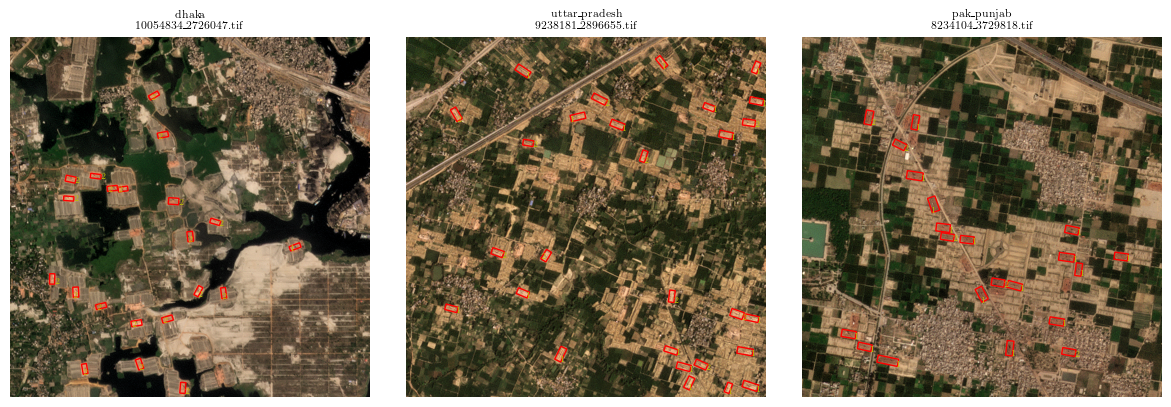

In [4]:

valid = []

for d in sub_dirs:
    path = os.path.join(root_dir, d)
    imgs = sorted(glob.glob(os.path.join(path, "*.tif")))
    best = max(((p, sum(1 for l in open(os.path.join(path, "labels", os.path.basename(p).replace(".tif", ".txt"))) if len(l.split()) >= 9))
                for p in imgs if os.path.exists(os.path.join(path, "labels", os.path.basename(p).replace(".tif", ".txt")))),
               key=lambda x: x[1], default=(None, 0))[0]
    if best:
        label = os.path.join(path, "labels", os.path.basename(best).replace(".tif", ".txt"))
        valid.append((d, best, label))

fig, axs = plt.subplots(1, len(valid), figsize=(4 * len(valid), 4))
if len(valid) == 1: axs = [axs]

for ax, (d, img_p, lbl_p) in zip(axs, valid):
    with rasterio.open(img_p) as src:
        img = np.transpose(src.read([1, 2, 3]), (1, 2, 0))
        h, w = img.shape[:2]
    ax.imshow(img)
    for ln in open(lbl_p):
        p = ln.strip().split()
        if len(p) < 9: continue
        pts = [(float(p[i]) * w, float(p[i+1]) * h) for i in range(1, 8, 2)]
        ax.add_patch(MplPolygon(pts, closed=True, edgecolor='r', facecolor='none', lw=1))
        ax.text(pts[0][0], pts[0][1], p[0], color='y', fontsize=6)
    ax.set_title(f"{d}\n{os.path.basename(img_p)}", fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.show()


In [5]:
img_size = 640  
label_counts = defaultdict(lambda: defaultdict(int))
denormalized_boxes = defaultdict(list)
label_dimensions = defaultdict(lambda: defaultdict(list))
for sub_dir in sub_dirs:
    label_paths = glob.glob(os.path.join(root_dir, sub_dir, "labels", "*.txt"))
    for label_path in label_paths:
        with open(label_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                label = parts[0]
                coords = list(map(float, parts[1:]))
                denorm = [(coords[i] * img_size, coords[i + 1] * img_size) for i in range(0, 8, 2)]
                # print(f"Label: {label}, Denormalized Coords: {denorm}")
                xs, ys = zip(*denorm)
                # print(f"  Xs: {xs}, Ys: {ys}")
                width = max(xs) - min(xs)
                # print(f"  Width: {width}")
                height = max(ys) - min(ys)
                # print(f"  Width: {width}, Height: {height}")
                denormalized_boxes[sub_dir].append((label, denorm))
                label_counts[sub_dir][label] += 1
                label_dimensions[sub_dir][label].append((width, height))
    print(f"\n{sub_dir}:")
    for label, dims in label_dimensions[sub_dir].items():
        widths = np.array([w for w, _ in dims])
        heights = np.array([h for _, h in dims])
        avg_w = widths.mean()
        avg_h = heights.mean()
        var_w = widths.var()
        var_h = heights.var()
        print(f"  Label {label} — Width: {avg_w:.2f} ± {var_w**0.5:.2f}, Height: {avg_h:.2f} ± {var_h**0.5:.2f}, Count: {len(dims)}")
            

    



dhaka:
  Label 2 — Width: 16.60 ± 4.20, Height: 15.58 ± 4.35, Count: 1362
  Label 1 — Width: 17.89 ± 4.25, Height: 17.00 ± 5.27, Count: 101



uttar_pradesh:
  Label 1 — Width: 23.42 ± 5.51, Height: 23.41 ± 5.15, Count: 12076
  Label 0 — Width: 17.51 ± 3.26, Height: 17.50 ± 3.23, Count: 1831
  Label 2 — Width: 23.49 ± 5.53, Height: 23.55 ± 5.17, Count: 7050

pak_punjab:
  Label 1 — Width: 20.21 ± 5.90, Height: 20.17 ± 6.02, Count: 6661
  Label 2 — Width: 20.79 ± 6.38, Height: 20.82 ± 6.42, Count: 1729


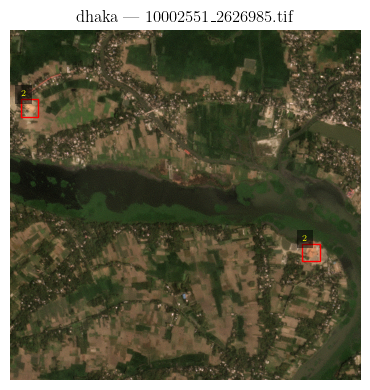

In [6]:
root_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_classification"
img_size = 640
box_size = 32

# Find one valid image-label pair
for sub_dir in os.listdir(root_dir):
    full_subdir = os.path.join(root_dir, sub_dir)
    if not os.path.isdir(full_subdir):
        continue
    images = sorted(glob.glob(os.path.join(full_subdir, "*.tif")))
    for img_path in images:
        label_path = os.path.join(full_subdir, "labels", os.path.basename(img_path).replace(".tif", ".txt"))
        if os.path.exists(label_path):
            break
    else:
        continue
    break

# Load image
with rasterio.open(img_path) as src:
    img = src.read([1, 2, 3])
    img = np.transpose(img, (1, 2, 0))
    h, w = img.shape[:2]

# Read and denormalize labels
boxes = []
with open(label_path, "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) < 9:
            continue
        label = parts[0]
        coords = list(map(float, parts[1:]))
        denorm = [(coords[i] * img_size, coords[i + 1] * img_size) for i in range(0, 8, 2)]
        xs, ys = zip(*denorm)
        cx, cy = np.mean(xs), np.mean(ys)
        x0 = max(cx - box_size / 2, 0)
        y0 = max(cy - box_size / 2, 0)
        boxes.append((label, x0, y0))

# Plot
fig, ax = plt.subplots(figsize=(4, 4))
ax.imshow(img)
ax.set_title(f"{sub_dir} — {os.path.basename(img_path)}")

for label, x0, y0 in boxes:
    rect = Rectangle((x0, y0), box_size, box_size, edgecolor='red', facecolor='none', linewidth=1)
    ax.add_patch(rect)
    ax.text(x0, y0 - 5, f"{label}", fontsize=6, color='yellow',
            bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))

ax.axis("off")
plt.tight_layout()
plt.show()


# Find the embedding of the labels crop difference between the different states.

In [7]:
device = "cuda:3" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda:3


In [8]:
resnet18=models.resnet18(pretrained=True)
resnet18.fc=torch.nn.Identity()
resnet18=resnet18.to(device)
checkpoint_path="../checkpoints_for_crops/dhaka_resnet18_epoch_50.pth"
assert os.path.exists(checkpoint_path), f"Checkpoint file {checkpoint_path} does not exist."
checkpoint = torch.load(checkpoint_path, map_location=device)
resnet18.load_state_dict(checkpoint,strict=False)
model=resnet18.eval()

In [9]:
import os
import glob
import numpy as np
from PIL import Image

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_vit = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

class ImageDataset(Dataset):
    def __init__(self, image_paths, transform):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert("RGB")
        return self.transform(img)

def extract_embeddings(model, image_paths, transform, batch_size=64):
    dataset = ImageDataset(image_paths, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    embeddings = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm.tqdm(loader):
            batch = batch.to(device)
            feats = model(batch)
            embeddings.append(feats.cpu().numpy())
    return np.concatenate(embeddings, axis=0)

def load_model(model_name, checkpoint_path):
    if "resnet18" in model_name:
        model = models.resnet18(pretrained=False)
        model.fc = nn.Identity()
    elif "resnet50" in model_name:
        model = models.resnet50(pretrained=False)
        model.fc = nn.Identity()
    elif "vit" in model_name:
        model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=0)
    else:
        raise ValueError("Unsupported model")
    state = torch.load(checkpoint_path, map_location="cpu")
    model.load_state_dict(state, strict=False)
    return model.to(device)

domains = {
    "dhaka": {
        "paths": [
            "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_crop_classification/dhaka/1",
            "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_crop_classification/dhaka/2"
        ],
        "checkpoints": {
            "resnet18": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints_for_crops/dhaka_resnet18_epoch_50.pth",
            "resnet50": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints_for_crops/dhaka_resnet50_epoch_50.pth",
            "vit": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints_for_crops/dhaka_vit_base_patch16_224_epoch_50.pth"
        }
    },
    "pak_punjab": {
        "paths": [
            "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_crop_classification/pak_punjab/1",
            "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_crop_classification/pak_punjab/2"
        ],
        "checkpoints": {
            "resnet18": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints_for_crops/pak_punjab_resnet18_epoch_50.pth",
            "resnet50": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints_for_crops/pak_punjab_resnet50_epoch_50.pth",
            "vit": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints_for_crops/pak_punjab_vit_base_patch16_224_epoch_50.pth"
        }
    },
    "uttar_pradesh": {
        "paths": [
            "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_crop_classification/uttar_pradesh/0",
            "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_crop_classification/uttar_pradesh/1",
            "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/data/continent_crop_classification/uttar_pradesh/2"
        ],
        "checkpoints": {
            "resnet18": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints_for_crops/uttar_pradesh_resnet18_epoch_50.pth",
            "resnet50": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints_for_crops/uttar_pradesh_resnet50_epoch_50.pth",
            "vit": "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/checkpoints_for_crops/uttar_pradesh_vit_base_patch16_224_epoch_50.pth"
        }
    }
}

all_embeddings = {}

for domain, info in domains.items():
    for model_type, ckpt in info["checkpoints"].items():
        model = load_model(model_type, ckpt)
        transform = transform_resnet if "resnet" in model_type else transform_vit
        for i, path in enumerate(info["paths"]):
            image_files = glob.glob(os.path.join(path, "*.png"))
            key = f"{domain}_{model_type}_class{i+1}"
            all_embeddings[key] = extract_embeddings(model, image_files, transform)
# Save embeddings to disk
output_dir = "/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/embeddings"
os.makedirs(output_dir, exist_ok=True)
for key, embeddings in all_embeddings.items():
    output_path = os.path.join(output_dir, f"{key}_embeddings.npy")
    np.save(output_path, embeddings)
    print(f"Saved {key} embeddings to {output_path}")   
    


100%|██████████| 109/109 [00:26<00:00,  4.16it/s]


Saved dhaka_resnet18_class1 embeddings to /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/embeddings/dhaka_resnet18_class1_embeddings.npy
Saved dhaka_resnet18_class2 embeddings to /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/embeddings/dhaka_resnet18_class2_embeddings.npy
Saved dhaka_resnet50_class1 embeddings to /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/embeddings/dhaka_resnet50_class1_embeddings.npy
Saved dhaka_resnet50_class2 embeddings to /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/embeddings/dhaka_resnet50_class2_embeddings.npy
Saved dhaka_vit_class1 embeddings to /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/embeddings/dhaka_vit_class1_embeddings.npy
Saved dhaka_vit_class2 embeddings to /home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/embeddings/dhaka_vit_class2_embeddings.npy
Saved pak_punjab_resnet1

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np


len(all_embeddings)
# all_embeddings
embeddings_r18_dhaka_class1 = all_embeddings["dhaka_resnet18_class1"]
embeddings_r18_dhaka_class2 = all_embeddings["dhaka_resnet18_class2"]
embeddings_r50_dhaka_class1 = all_embeddings["dhaka_resnet50_class1"]
embeddings_r50_dhaka_class2 = all_embeddings["dhaka_resnet50_class2"]
embeddings_vit_dhaka_class1 = all_embeddings["dhaka_vit_class1"]
embeddings_vit_dhaka_class2 = all_embeddings["dhaka_vit_class2"]    
embeddings_r18_pakpunjab_class1 = all_embeddings["pak_punjab_resnet18_class1"]
embeddings_r18_pakpunjab_class2 = all_embeddings["pak_punjab_resnet18_class2"]
embeddings_r50_pakpunjab_class1 = all_embeddings["pak_punjab_resnet50_class1"]
embeddings_r50_pakpunjab_class2 = all_embeddings["pak_punjab_resnet50_class2"]
embeddings_vit_pakpunjab_class1 = all_embeddings["pak_punjab_vit_class1"]
embeddings_vit_pakpunjab_class2 = all_embeddings["pak_punjab_vit_class2"]
embeddings_r18_up_class1 = all_embeddings["uttar_pradesh_resnet18_class1"]
embeddings_r18_up_class2 = all_embeddings["uttar_pradesh_resnet18_class2"]
embeddings_r18_up_class3 = all_embeddings["uttar_pradesh_resnet18_class3"]
embeddings_r50_up_class1 = all_embeddings["uttar_pradesh_resnet50_class1"]
embeddings_r50_up_class2 = all_embeddings["uttar_pradesh_resnet50_class2"]
embeddings_r50_up_class3 = all_embeddings["uttar_pradesh_resnet50_class3"]
embeddings_vit_up_class1 = all_embeddings["uttar_pradesh_vit_class1"]
embeddings_vit_up_class2 = all_embeddings["uttar_pradesh_vit_class2"]
embeddings_vit_up_class3 = all_embeddings["uttar_pradesh_vit_class3"]

print(f"Embeddings shapes: \n"
      f"ResNet18 Dhaka Class 1: {embeddings_r18_dhaka_class1.shape}, \n"
      f"ResNet18 Dhaka Class 2: {embeddings_r18_dhaka_class2.shape}, \n"
      f"ResNet50 Dhaka Class 1: {embeddings_r50_dhaka_class1.shape}, \n"
        f"ResNet50 Dhaka Class 2: {embeddings_r50_dhaka_class2.shape}, \n"
      f"ViT Dhaka Class 1: {embeddings_vit_dhaka_class1.shape}, \n"
        f"ViT Dhaka Class 2: {embeddings_vit_dhaka_class2.shape}, \n"
      f"ResNet18 Pak Punjab Class 1: {embeddings_r18_pakpunjab_class1.shape}, \n"
      f"ResNet18 Pak Punjab Class 2: {embeddings_r18_pakpunjab_class2.shape}, \n"
      f"ResNet50 Pak Punjab Class 1: {embeddings_r50_pakpunjab_class1.shape}, \n"
        f"ResNet50 Pak Punjab Class 2: {embeddings_r50_pakpunjab_class2.shape}, \n"
      f"ViT Pak Punjab Class 1: {embeddings_vit_pakpunjab_class1.shape}, \n"
      f"ViT Pak Punjab Class 2: {embeddings_vit_pakpunjab_class2.shape}, \n"
      f"ResNet18 UP Class 1: {embeddings_r18_up_class1.shape}, \n"
      f"ResNet18 UP Class 2: {embeddings_r18_up_class2.shape}, \n"
      f"ResNet18 UP Class 3: {embeddings_r18_up_class3.shape}, \n"
      f"ResNet50 UP Class 1: {embeddings_r50_up_class1.shape}, \n"
        f"ResNet50 UP Class 2: {embeddings_r50_up_class2.shape}, \n"
      f"ResNet50 UP Class 3: {embeddings_r50_up_class3.shape}, \n"
      f"ViT UP Class 1: {embeddings_vit_up_class1.shape}, \n"
      f"ViT UP Class 2: {embeddings_vit_up_class2.shape}, \n"
      f"ViT UP Class 3  : {embeddings_vit_up_class3.shape})")



Embeddings shapes: 
ResNet18 Dhaka Class 1: (96, 512), 
ResNet18 Dhaka Class 2: (1331, 512), 
ResNet50 Dhaka Class 1: (96, 2048), 
ResNet50 Dhaka Class 2: (1331, 2048), 
ViT Dhaka Class 1: (96, 768), 
ViT Dhaka Class 2: (1331, 768), 
ResNet18 Pak Punjab Class 1: (6536, 512), 
ResNet18 Pak Punjab Class 2: (1697, 512), 
ResNet50 Pak Punjab Class 1: (6536, 2048), 
ResNet50 Pak Punjab Class 2: (1697, 2048), 
ViT Pak Punjab Class 1: (6536, 768), 
ViT Pak Punjab Class 2: (1697, 768), 
ResNet18 UP Class 1: (1788, 512), 
ResNet18 UP Class 2: (11947, 512), 
ResNet18 UP Class 3: (6976, 512), 
ResNet50 UP Class 1: (1788, 2048), 
ResNet50 UP Class 2: (11947, 2048), 
ResNet50 UP Class 3: (6976, 2048), 
ViT UP Class 1: (1788, 768), 
ViT UP Class 2: (11947, 768), 
ViT UP Class 3  : (6976, 768))


In [11]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
output_dir="/home/rishabh.mondal/Brick-Kilns-project/ijcai_2025_kilns/domain_experiment/figures"
# Global plotting parameters
fig_width, fig_height = 8, 6
fontsize_pt = 12

# Filter embeddings by model type
embeddings_r18 = {k: v for k, v in all_embeddings.items() if "resnet18" in k}
embeddings_r50 = {k: v for k, v in all_embeddings.items() if "resnet50" in k}
embeddings_vit = {k: v for k, v in all_embeddings.items() if "vit" in k}

def plot_tsne(embedding_dict, title, output_path):
    reduced_embeddings = {}
    for key, embed in embedding_dict.items():
        n_components = min(50, embed.shape[0], embed.shape[1])
        pca = PCA(n_components=n_components)
        reduced_embeddings[key] = pca.fit_transform(embed)

    all_embeds = []
    all_labels = []

    for key, embed in reduced_embeddings.items():
        all_embeds.append(embed)
        all_labels.extend([key] * embed.shape[0])

    all_embeds = np.vstack(all_embeds)

    tsne = TSNE(n_components=2, perplexity=30, init='random', random_state=42)
    embeds_2d = tsne.fit_transform(all_embeds)

    plt.figure(figsize=(fig_width, fig_height))
    palette = sns.color_palette("husl", len(set(all_labels)))
    unique_labels = sorted(set(all_labels))

    for idx, label in enumerate(unique_labels):
        indices = [i for i, l in enumerate(all_labels) if l == label]
        plt.scatter(embeds_2d[indices, 0], embeds_2d[indices, 1],
                    label=label, alpha=0.65, color=palette[idx],
                    edgecolor='black', linewidth=0.4, s=25)

    plt.title(title, fontsize=fontsize_pt + 2)
    plt.xlabel("t-SNE Component 1", fontsize=fontsize_pt)
    plt.ylabel("t-SNE Component 2", fontsize=fontsize_pt)
    plt.legend(title="Source-Class", loc='best', frameon=True,
               fontsize=fontsize_pt * 0.85, title_fontsize=fontsize_pt * 0.95)
    plt.grid(True, linestyle='--', linewidth=0.4, alpha=0.3)
    sns.despine()
    plt.tight_layout()

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    plt.savefig(output_path, dpi=600, bbox_inches='tight')
    plt.close()

# Execute plots
plot_tsne(embeddings_r18, "t-SNE of ResNet-18 Embeddings", f"{output_dir}/resnet18_tsne.pdf")
print("t-SNE plots saved successfully.")
plot_tsne(embeddings_r50, "t-SNE of ResNet-50 Embeddings", f"{output_dir}/resnet50_tsne.pdf")
print("t-SNE plots saved successfully.")
plot_tsne(embeddings_vit, "t-SNE of ViT Embeddings", f"{output_dir}/vit_tsne.pdf")
print("t-SNE plots saved successfully.")


t-SNE plots saved successfully.
t-SNE plots saved successfully.
t-SNE plots saved successfully.


In [12]:
from sklearn.metrics.pairwise import cosine_similarity

def compute_mean_cosine_similarity(embedding_dict):
    similarities = {}
    for key1, emb1 in embedding_dict.items():
        for key2, emb2 in embedding_dict.items():
            if key1 >= key2:
                continue  # avoid duplicate pairs and self-comparison

            # Normalize embeddings
            emb1_norm = emb1 / np.linalg.norm(emb1, axis=1, keepdims=True)
            emb2_norm = emb2 / np.linalg.norm(emb2, axis=1, keepdims=True)

            # Compute pairwise cosine similarity
            sim_matrix = cosine_similarity(emb1_norm, emb2_norm)
            mean_sim = np.mean(sim_matrix)

            similarities[(key1, key2)] = mean_sim
    return similarities

# Compute cosine similarity
similarities_r18 = compute_mean_cosine_similarity(embeddings_r18)
similarities_r50 = compute_mean_cosine_similarity(embeddings_r50)
similarities_vit = compute_mean_cosine_similarity(embeddings_vit)

# Print results
print("Mean Cosine Similarities (ResNet18):")
for pair, score in similarities_r18.items():
    print(f"{pair}: {score:.4f}")

print("\nMean Cosine Similarities (ResNet50):")
for pair, score in similarities_r50.items():
    print(f"{pair}: {score:.4f}")

print("\nMean Cosine Similarities (ViT):")
for pair, score in similarities_vit.items():
    print(f"{pair}: {score:.4f}")


Mean Cosine Similarities (ResNet18):
('dhaka_resnet18_class1', 'dhaka_resnet18_class2'): 0.1261
('dhaka_resnet18_class1', 'pak_punjab_resnet18_class1'): 0.2359
('dhaka_resnet18_class1', 'pak_punjab_resnet18_class2'): 0.1913
('dhaka_resnet18_class1', 'uttar_pradesh_resnet18_class1'): 0.2457
('dhaka_resnet18_class1', 'uttar_pradesh_resnet18_class2'): 0.2054
('dhaka_resnet18_class1', 'uttar_pradesh_resnet18_class3'): 0.2514
('dhaka_resnet18_class2', 'pak_punjab_resnet18_class1'): 0.6626
('dhaka_resnet18_class2', 'pak_punjab_resnet18_class2'): 0.4309
('dhaka_resnet18_class2', 'uttar_pradesh_resnet18_class1'): 0.4223
('dhaka_resnet18_class2', 'uttar_pradesh_resnet18_class2'): 0.6049
('dhaka_resnet18_class2', 'uttar_pradesh_resnet18_class3'): 0.5282
('pak_punjab_resnet18_class1', 'pak_punjab_resnet18_class2'): 0.2173
('pak_punjab_resnet18_class1', 'uttar_pradesh_resnet18_class1'): 0.4048
('pak_punjab_resnet18_class1', 'uttar_pradesh_resnet18_class2'): 0.5781
('pak_punjab_resnet18_class1', 'u

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

fig_width, fig_height = 8, 6
fontsize_pt = 12
cmap = "viridis"

def plot_heatmap(embedding_dict, title, filename):
    keys = list(embedding_dict.keys())
    n = len(keys)
    matrix = np.zeros((n, n))
    annotations = np.empty((n, n), dtype=object)

    for i, ki in enumerate(keys):
        for j, kj in enumerate(keys):
            emb_i = embedding_dict[ki] / np.linalg.norm(embedding_dict[ki], axis=1, keepdims=True)
            emb_j = embedding_dict[kj] / np.linalg.norm(embedding_dict[kj], axis=1, keepdims=True)
            sim = cosine_similarity(emb_i, emb_j)
            mean = sim.mean()
            std = sim.std()
            matrix[i, j] = mean
            annotations[i, j] = f"{mean:.1f}"

    fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    sns.heatmap(matrix, annot=annotations, fmt="", cmap=cmap,
                xticklabels=keys, yticklabels=keys,
                cbar_kws={"label": "Cosine Similarity"}, square=True,
                linewidths=0.6, linecolor='lightgray',
                annot_kws={"fontsize": fontsize_pt * 0.9}, ax=ax)
    ax.set_title(title, fontsize=fontsize_pt * 1.2, weight='semibold')
    ax.tick_params(axis='x', rotation=30)
    ax.tick_params(axis='y', rotation=0)
    plt.tight_layout()
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    plt.close()

# Usage:
plot_heatmap(embeddings_r18, "Cosine Similarity - ResNet-18_crops", "cosine_similarity_r18_crops.pdf")
plot_heatmap(embeddings_r50, "Cosine Similarity - ResNet-50_crops", "cosine_similarity_r50_crops.pdf")
plot_heatmap(embeddings_vit, "Cosine Similarity - ViT_crops", "cosine_similarity_vit_crops.pdf")


In [ ]:
from datatree import open_datatree

tree = open_datatree("https://huggingface.co/datasets/gajeshladhar/core-five/resolve/main/src/datatree/1a220b/1a220c04.nc")
s2 = tree["s2"]


syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: Entry^ not found


OSError: [Errno -90] NetCDF: file not found: 'https://huggingface.co/datasets/gajeshladhar/core-five/resolve/main/src/datatree/1a220b/1a220c04.nc'

: 